In [1]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np

import matplotlib.pyplot as plt

from model import BinaryLinear

# Doing 2d Pooling to reduce image size

(we want 8x8's from 32x32's, so a 2d pool of 4x4 filters with 4 stride would work)

In [2]:
def reduce_image_avg(X, filter_size, stride_size):
    """
    :param X: NxN image.
    :param filter_size: the size of the filter e.g. (4x4) = 4
    :param stride_size: the stride size
    """
    tX = torch.from_numpy(X)
    ty = torch.nn.MaxPool2d(kernel_size=filter_size, stride=stride_size)(tX)
    y = ty.numpy()
    return y

# Taking binarized input data for MNIST

In [3]:
test_dataset = torchvision.datasets.MNIST(root='torch_dataset', 
                                          train=True, 
                                          transform=transforms.Compose([
                                                              transforms.ToTensor(), # first, convert image to PyTorch tensor
                                                          ]),
                                          download=True)

dataset = list(test_dataset)
dataset = [x for x in dataset if x[1] < 5]
# filter by only 0, 1, 2, 3, 4

X = np.array([_x[0].numpy() for _x in dataset])
y = np.array([_x[1] for _x in dataset])

X = reduce_image_avg(X, 4, 4)

X[X < 0.5] = 0
X[X > 0.5] = 1
X = X.astype(np.uint8)

## Sanity Check

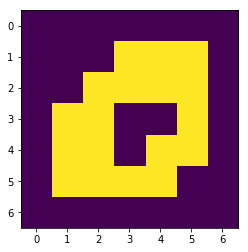

Label : 0


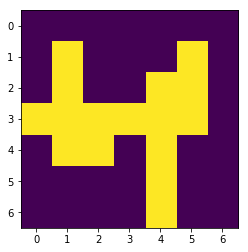

Label : 4


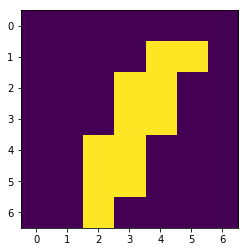

Label : 1


In [4]:
for i in range(3):
    plt.imshow(X[i][0])
    plt.show()
    print('Label : {}'.format(y[i]))

## Saving the matrix (We feed in the FPGA using flattened matrix)

In [5]:
np.save('matrices/bin_mnist_3d_tensor.npz', X)
X = X.reshape(X.shape[0], -1)
np.save('matrices/bin_mnist_flat.npz', X)

# Pytorch preprocessing

In [6]:
train_data = torch.utils.data.TensorDataset(torch.from_numpy(X.astype(np.float32)), torch.from_numpy(y))
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)

# Try to train a torch model on it

In [7]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 2 layer neural network
class Net(nn.Module):
    def __init__(self, num_classes=5):
        super(Net, self).__init__()
        self.fc = BinaryLinear(49, 5)
        
    def forward(self, x):
        out = self.fc(x)
        return out

model = Net().to(device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train the model
total_step = len(train_loader)
losses = []

max_loss = float('inf')

In [8]:
def eval_model(model, train_loader, device):
    model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        acc = 100 * correct / total
        return acc

max_acc = 0
    
for epoch in range(10):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 50 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, 1, i+1, total_step, loss.item()))
            cur_acc = eval_model(model, train_loader, device)
            if cur_acc > max_acc:
                max_acc = cur_acc
                print('Test Accuracy of the model on the test images: {} %'.format(cur_acc))
                torch.save(model.state_dict(), 'model.ckpt')

Epoch [1/1], Step [50/957], Loss: 1.7428
Test Accuracy of the model on the test images: 38.877631062884035 %
Epoch [1/1], Step [100/957], Loss: 0.4911
Test Accuracy of the model on the test images: 68.99921558373643 %
Epoch [1/1], Step [150/957], Loss: 0.8834
Test Accuracy of the model on the test images: 71.3982219898026 %
Epoch [1/1], Step [200/957], Loss: 0.8392
Test Accuracy of the model on the test images: 75.24186168126552 %
Epoch [1/1], Step [250/957], Loss: 0.3316
Test Accuracy of the model on the test images: 82.04994116878024 %
Epoch [1/1], Step [300/957], Loss: 0.3459
Epoch [1/1], Step [350/957], Loss: 0.6902
Epoch [1/1], Step [400/957], Loss: 0.9732
Epoch [1/1], Step [450/957], Loss: 0.9771
Epoch [1/1], Step [500/957], Loss: 0.4339
Epoch [1/1], Step [550/957], Loss: 0.4236
Epoch [1/1], Step [600/957], Loss: 0.6645
Epoch [1/1], Step [650/957], Loss: 0.5989
Epoch [1/1], Step [700/957], Loss: 0.9015
Epoch [1/1], Step [750/957], Loss: 0.3992
Epoch [1/1], Step [800/957], Loss: 0

Epoch [10/1], Step [650/957], Loss: 1.4762
Epoch [10/1], Step [700/957], Loss: 0.8864
Epoch [10/1], Step [750/957], Loss: 0.9452
Epoch [10/1], Step [800/957], Loss: 0.6464
Epoch [10/1], Step [850/957], Loss: 0.4957
Epoch [10/1], Step [900/957], Loss: 0.8519
Epoch [10/1], Step [950/957], Loss: 0.9439


In [9]:
model.load_state_dict(torch.load('model.ckpt'))
params = dict(model.fc.named_parameters())

# Save the matrix

In [10]:
# To actually retrieve the values, we take the magnitude and the signs:
for pname in params:
    w = params[pname].data.cpu().numpy()
    sign = np.sign(w)
    sign[sign < 0] = 0
    sign = sign.astype(np.int8)
    np.save('{}'.format(pname), sign)

In [11]:
# sanity check
w = np.load('weight.npy').astype(int)
x = X.astype(int)

In [14]:
# Mimicking the FPGA's behavior for XNORNET:
def predict(data, weights):
    # Now try to classify the 4:
    idx_max = 0
    max_val = 0
    for class_idx, row in enumerate(weights):
        rx = data
        s = 0
        for a,b in zip(row, rx):
            s += a & b # (1-(a ^ b))
        if s > max_val:
            max_val = s
            idx_max = class_idx
    return idx_max

corrects = 0
n = 10000
for i in range(n):
    pred = predict(x[i], w)
    corrects += pred == y[i]
print(corrects, n)

print(np.mean(np.argmax(x.dot(w.T), axis=1) == y))

8357 10000
0.839717610145117
